# start

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cmo
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cl

def rolling_(df):
    lol=pd.DataFrame(df).interpolate(limit=5, axis=1).interpolate(limit=5, axis=0).rolling(1, center=True, axis=1).mean()
    return lol.to_numpy()


def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return rolling_(grid),XI.T,YI.T

import gsw
import glidertools as gt

ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2023_n30.0_s-5.0_w30.0_e80.0.nc')


from scipy.interpolate import interp1d
def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.5

GoO=[24, 58]
SAS=[12,62.5]
# UPW=[18, 58]
# EAS=[20,67]
SEAS=[14,71]
CAS=[18,62.5]

regions_names=['SoO',  'CAS','EAS', 'SAS']
regions=[GoO, CAS, SEAS, SAS]
colors_regions=["#ffb03f","#962d9e","#579404",
"firebrick"]#['k', 'green', 'lightblue', 'yellow','r']    


import warnings
warnings.filterwarnings('ignore')

# functions_

In [2]:
## GRID 3d 4d
GS=2
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)
# grid 3d for 3d variables (2d + time)

## grid pwp sum
def grid_lat_3dsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')

def grid_lon_3d_sum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dsum)
    
    
def grid_var_3dsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_sum)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_sum)
    return var


## grid pwp sum
def grid_lat_3d(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')

def grid_lon_3d_(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3d)
    
    
def grid_var_3d(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_)
    return var

## GRID 3d 4d
# def mode_func(array):
#     mode_result = stats.mode(array, axis=None)
#     return mode_result.mode[0]

# grid 3d for 3d variables (2d + time)
def grid_lat_3df(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_f(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3df)
    
    
def grid_var_3dflt(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_f)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_f)
    return var


# grid 3d for 3d variables (2d + time)
def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_fsum)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var


##  Load variables

In [3]:
# df_arg=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/argo_wwl_per_yr/L0/argo_wwl_0_578floats.nc')
# for i in list(df_arg.variables):
#     df_arg=df_arg.rename({i:i+'_f'})    
# df_arg=df_arg.rename({'N2_f':'n2_f','N2_roll_f':'n2_roll_f', 'min_n2_f':'min_n2_depth_f'})

# def center_properties(dff,variablee):
#     dff['core_'+variablee]=dff[variablee].sel(pressure_f=dff.min_n2_depth_f.fillna(0))*((dff.min_n2_depth_f/dff.min_n2_depth_f))
    
# df_arg['alpha']=gsw.alpha(df_arg.abs_salinity_f, df_arg.cons_temp_f, df_arg.pressure_f)
# df_arg['beta']=gsw.beta(df_arg.abs_salinity_f, df_arg.cons_temp_f, df_arg.pressure_f)

# df_arg['n2_T_f']=df_arg['alpha']*9.8*(df_arg['cons_temp_f'].diff('pressure_f')/-df_arg['pressure_f'].diff('pressure_f'))
# df_arg['n2_S_f']=-df_arg['beta']*9.8*(df_arg['abs_salinity_f'].diff('pressure_f')/-df_arg['pressure_f'].diff('pressure_f'))

## Load ARGO

In [4]:
df_mld=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/mld.nc').sortby('platform_num_f').set_coords(['latitude_f', 'longitude_f'])
df_mwt=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/thickness_mw.nc').sortby('platform_num_f').set_coords(['latitude_f', 'longitude_f'])# df_mwt=ds_get_float_pwp_1D('mw_thickness')

df_N2=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/all_n2_mw.nc')
df_N2=df_N2.set_coords(['latitude_f', 'longitude_f']).sortby('platform_num_f')

df_N2T=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/n2_T.nc')
df_N2T=df_N2T.set_coords(['latitude_f', 'longitude_f']).sortby('platform_num_f')

df_N2S=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/n2_S.nc')
df_N2S=df_N2S.set_coords(['latitude_f', 'longitude_f']).sortby('platform_num_f')

df_top=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/top_mw.nc')
df_bot=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/bot_mw.nc')
df_bot=df_bot.set_coords(['latitude_f', 'longitude_f']).sortby('platform_num_f')
df_top=df_top.set_coords(['latitude_f', 'longitude_f']).sortby('platform_num_f')


dff_presence=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/presence_mw.nc')
dff_presence=dff_presence.sortby('platform_num_f')

dff_presence['lat_pp']=dff_presence.latitude_f.mean('time_f')
dff_presence['lon_pp']=dff_presence.longitude_f.mean('time_f')

## only foramtion
dff_presence_1 = dff_presence.where(dff_presence != 0, np.nan)
dff_presence_1 = dff_presence_1.where(dff_presence != 2, np.nan)

## only duration
dff_presence_2 = dff_presence.where(dff_presence != 0, np.nan)
dff_presence_2 = dff_presence_2.where(dff_presence != 1, np.nan)
dff_presence_2 = dff_presence_2.where(dff_presence !=2, 1)

# no mode water
dff_presence_0 = dff_presence.where(dff_presence != 1, np.nan)
dff_presence_0 = dff_presence_0.where(dff_presence != 2, np.nan)
dff_presence_0 = dff_presence_0.where(dff_presence!=0, 1)

mask_pres=((dff_presence_0.presence_mwl_f.fillna(0).values+dff_presence_1.presence_mwl_f.fillna(0).values)==1).astype(float)
mask_pres[mask_pres==0]=np.nan

mask_thic=(df_mwt.mw_thickness_f>10).values.astype(float)
mask_thic[mask_thic==0]=np.nan


del dff_presence_1, dff_presence_2, dff_presence_0, df_mwt


In [5]:
#week
df_grid_mld_f_week=grid_var_3dflt(df_mld.mixed_layer_depth_f, clim='week', gs=GS) ##3min
df_grid_mld_f_week['longitude_f_bins']=lonn[:-1]+GS/2
df_grid_mld_f_week['latitude_f_bins']=latt[:-1]++GS/2

del df_mld

df_grid_n2_f=grid_var_3dflt(df_N2.n2_f, clim='week', gs=GS) ##3min
df_grid_n2_f['longitude_f_bins']=lonn[:-1]+GS/2
df_grid_n2_f['latitude_f_bins']=latt[:-1]+GS/2

del df_N2

df_grid_n2T_f=grid_var_3dflt(df_N2T.n2_T_f, clim='week', gs=GS) ##3min
df_grid_n2T_f['longitude_f_bins']=lonn[:-1]+GS/2
df_grid_n2T_f['latitude_f_bins']=latt[:-1]+GS/2

del df_N2T

df_grid_n2S_f=grid_var_3dflt(df_N2S.n2_S_f, clim='week', gs=GS) ##3min
df_grid_n2S_f['longitude_f_bins']=lonn[:-1]+GS/2
df_grid_n2S_f['latitude_f_bins']=latt[:-1]+GS/2

del df_N2S

df_top['top_mwl_f_msk']=(('platform_num_f', 'time_f'), (df_top.top_mwl_f.values)*mask_thic*mask_pres)
df_bot['bot_mwl_f_msk']=(('platform_num_f', 'time_f'), (df_bot.bot_mwl_f.values)*mask_thic*mask_pres)

df_grid_bot_f=grid_var_3dflt(df_bot.bot_mwl_f_msk, clim='week', gs=GS) 
df_grid_bot_f['longitude_f_bins']=lonn[:-1]+GS/2
df_grid_bot_f['latitude_f_bins']=latt[:-1]+GS/2

df_grid_top_f=grid_var_3dflt(df_top.top_mwl_f_msk, clim='week', gs=GS) 
df_grid_top_f['longitude_f_bins']=lonn[:-1]+GS/2
df_grid_top_f['latitude_f_bins']=latt[:-1]+GS/2

del df_top, df_bot

## Load GOTM


In [6]:
df_top_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/top_mwl_gotm_all.nc').set_coords(['latitude', 'longitude']).sortby('platform_num_f')
df_bot_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/bot_mwl_gotm_all.nc').set_coords(['latitude', 'longitude']).sortby('platform_num_f')
df_mld_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mixed_layer_depth_gotm_all.nc').set_coords(['latitude', 'longitude']).sortby('platform_num_f')
df_mwt_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mw_thickness_gotm_all.nc').set_coords(['latitude', 'longitude']).sortby('platform_num_f')

df_presence_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/presence_mwl_gotm_all.nc').sortby('platform_num_f')
df_presence_gotm['lat_pp']=df_presence_gotm.latitude.mean('time')
df_presence_gotm['lon_pp']=df_presence_gotm.longitude.mean('time')

## only foramtion
dff_presence_1_gtm = df_presence_gotm.where(df_presence_gotm != 0, np.nan)
dff_presence_1_gtm = dff_presence_1_gtm.where(df_presence_gotm != 2, np.nan)
## only duration
dff_presence_2_gtm = df_presence_gotm.where(df_presence_gotm != 0, np.nan)
dff_presence_2_gtm = dff_presence_2_gtm.where(df_presence_gotm != 1, np.nan)
dff_presence_2_gtm = dff_presence_2_gtm.where(df_presence_gotm !=2, 1)
# no mode water
dff_presence_0_gtm = df_presence_gotm.where(df_presence_gotm != 1, np.nan)
dff_presence_0_gtm = dff_presence_0_gtm.where(df_presence_gotm != 2, np.nan)
dff_presence_0_gtm = dff_presence_0_gtm.where(df_presence_gotm!=0, 1)


mask_pres_gtm=((dff_presence_0_gtm.presence_mwl.fillna(0).values+dff_presence_1_gtm.presence_mwl.fillna(0).values)==1).astype(float)
mask_pres_gtm[mask_pres_gtm==0]=np.nan

mask_thic_gtm=(df_mwt_gotm.mw_thickness>10).values.astype(float)
mask_thic_gtm[mask_thic_gtm==0]=np.nan

del dff_presence_0_gtm, dff_presence_2_gtm, dff_presence_1_gtm, df_presence_gotm, df_mwt_gotm

df_top_gotm['top_mwl_f_msk']=(('platform_num_f', 'time'), (df_top_gotm.top_mwl.values)*mask_pres_gtm*mask_thic_gtm)
df_bot_gotm['bot_mwl_f_msk']=(('platform_num_f', 'time'), (df_bot_gotm.bot_mwl.values)*mask_pres_gtm*mask_thic_gtm)


####

df_n2_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/N2_gotm_all.nc').sortby('platform_num_f')
df_sa_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/abs_salinity_gotm_all.nc').sortby('platform_num_f')
df_ct_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/cons_temp_gotm_all.nc').sortby('platform_num_f')

df_sa_gotm['alpha']=gsw.alpha(df_sa_gotm.abs_salinity, df_ct_gotm.cons_temp, df_sa_gotm.pressure)
df_sa_gotm['beta']=gsw.beta(df_sa_gotm.abs_salinity, df_ct_gotm.cons_temp, df_sa_gotm.pressure)

df_n2_gotm['n2_T_f']=df_sa_gotm['alpha']*9.8*(df_ct_gotm['cons_temp'].diff('pressure')/-df_ct_gotm['pressure'].diff('pressure'))
df_n2_gotm['n2_S_f']=-df_sa_gotm['beta']*9.8*(df_sa_gotm['abs_salinity'].diff('pressure')/-df_sa_gotm['pressure'].diff('pressure'))
df_n2_gotm=df_n2_gotm.set_coords(['latitude', 'longitude'])

del df_sa_gotm, df_ct_gotm

In [7]:
#week
df_grid_mld_pwp_wee=grid_var_3d(df_mld_gotm.mixed_layer_depth, clim='week', gs=GS) ##3min
df_grid_mld_pwp_wee['longitude_bins']=lonn[:-1]+GS/2
df_grid_mld_pwp_wee['latitude_bins']=latt[:-1]+GS/2

del df_mld_gotm

df_grid_n2_pwp=grid_var_3d(df_n2_gotm.n2, clim='week', gs=GS) 
df_grid_n2_pwp['longitude_bins']=lonn[:-1]+GS/2
df_grid_n2_pwp['latitude_bins']=latt[:-1]+GS/2

df_grid_bot_pwp=grid_var_3d(df_bot_gotm.bot_mwl_f_msk, clim='week', gs=GS) 
df_grid_top_pwp=grid_var_3d(df_top_gotm.top_mwl_f_msk, clim='week', gs=GS) 
# 
df_grid_bot_pwp['longitude_bins']=lonn[:-1]+GS/2
df_grid_bot_pwp['latitude_bins']=latt[:-1]+GS/2
# 
df_grid_top_pwp['longitude_bins']=lonn[:-1]+GS/2
df_grid_top_pwp['latitude_bins']=latt[:-1]+GS/2

del df_bot_gotm, df_top_gotm

df_grid_n2S_pwp=grid_var_3d(df_n2_gotm.n2_S_f, clim='week', gs=GS) 
df_grid_n2S_pwp['longitude_bins']=lonn[:-1]+GS/2
df_grid_n2S_pwp['latitude_bins']=latt[:-1]+GS/2

df_grid_n2T_pwp=grid_var_3d(df_n2_gotm.n2_T_f, clim='week', gs=GS) 
df_grid_n2T_pwp['longitude_bins']=lonn[:-1]+GS/2
df_grid_n2T_pwp['latitude_bins']=latt[:-1]+GS/2

del df_n2_gotm

### Load TOPAZ

In [8]:
ds_topaz=xr.open_dataset('/home/jupyter-estelfont/common/fridge/TOPAZ_AS_2000_2020/TOPAZ_AS_2000_2020_z_0_250m.nc')
pressure_broadcasted = np.transpose(np.broadcast_to(ds_topaz.pressure, (2541, 120, 181, 27)), (0, 3, 1, 2))
ds_topaz['pressure_grid']=(('time', 'pressure', 'latitude', 'longitude'), pressure_broadcasted)
# 
ds_topaz_n2_mld=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_n2_mld.nc')
ds_topaz_mwd=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_mwl.nc')

ds_topaz=xr.merge([ds_topaz, ds_topaz_n2_mld, ds_topaz_mwd])

del ds_topaz_n2_mld, ds_topaz_mwd
ds_topaz['mw_thickness']=ds_topaz.bot_mwl-ds_topaz.top_mwl

seas=['DJF', 'JJA', 'MAM', 'SON']

dff_presence_1_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 0, np.nan)
dff_presence_1_topaz = dff_presence_1_topaz.where(ds_topaz.presence_mwl != 2, np.nan)

## only duration
dff_presence_2_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 0, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_topaz.presence_mwl != 1, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_topaz.presence_mwl !=2, 1)

# no mode water
dff_presence_0_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 1, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_topaz.presence_mwl != 2, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_topaz.presence_mwl !=0, 1)

mskk_topaz=np.nansum([dff_presence_1_topaz.values, dff_presence_0_topaz.values], axis=0)
mskk_topaz[mskk_topaz==0]=np.nan

del dff_presence_0_topaz, dff_presence_2_topaz, dff_presence_1_topaz

mask_thictopaz=(ds_topaz.mw_thickness>10).values.astype(float)
mask_thictopaz[mask_thictopaz==0]=np.nan

In [9]:
ds_topaz_week_n2=ds_topaz.n2.groupby('time.week').median()
ds_topaz_week_mld=ds_topaz.mixed_layer_depth.groupby('time.week').median()
ds_topaz_week_tmwl=(ds_topaz.top_mwl*mask_thictopaz*mskk_topaz).groupby('time.week').median()
ds_topaz_week_bmwl=(ds_topaz.bot_mwl*mask_thictopaz*mskk_topaz).groupby('time.week').median()

In [10]:
print('computing alpha and beta...')
ds_topaz['alpha']=gsw.alpha(ds_topaz.abs_salinity, ds_topaz.cons_temp, ds_topaz.pressure)
ds_topaz['beta']=gsw.beta(ds_topaz.abs_salinity, ds_topaz.cons_temp, ds_topaz.pressure)

print('computing alpha and beta stratification...')
ds_topaz['n2_T']=ds_topaz['alpha']*9.8*(ds_topaz['cons_temp'].diff('pressure')/-ds_topaz['pressure'].diff('pressure'))
ds_topaz['n2_S']=-ds_topaz['beta']*9.8*(ds_topaz['abs_salinity'].diff('pressure')/-ds_topaz['pressure'].diff('pressure'))
ds_topaz_week_n2S=ds_topaz.n2_S.groupby('time.week').median()
ds_topaz_week_n2T=ds_topaz.n2_T.groupby('time.week').median()

print('Done!')

computing alpha and beta...
computing alpha and beta stratification...
Done!


## SUPLMENTART stratifications!

In [11]:
GoO=[24, 58]
SAS=[12,62.5]
# UPW=[18, 58]
# EAS=[20,67]
SEAS=[14,71]
CAS=[18,62.5]

regions_names=['SoO',  'CAS','EAS', 'SAS']
regions=[GoO, CAS, SEAS, SAS]
colors_regions=["#ffb03f","#962d9e","#579404",
"firebrick"]#['k', 'green', 'lightblue', 'yellow','r']    


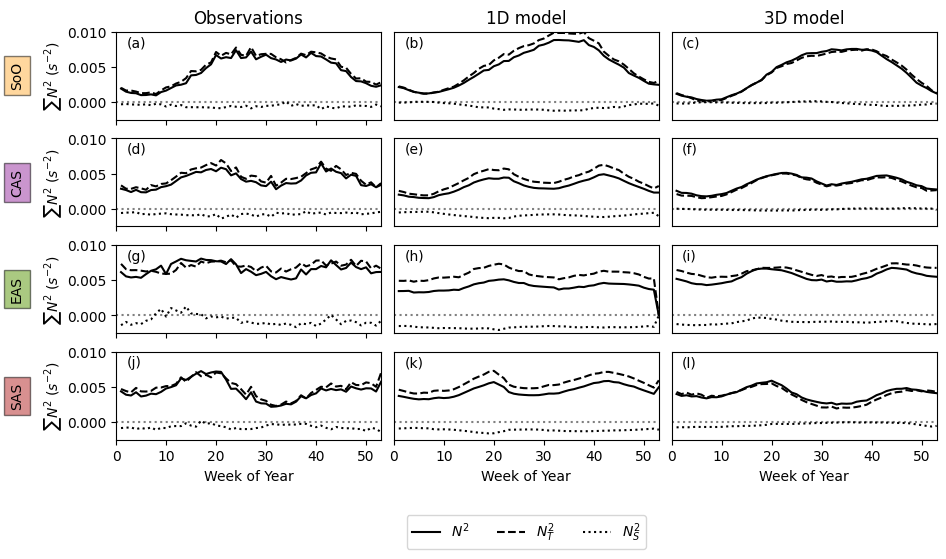

In [14]:
xx,yy=8,4
fig_sx, fig_sy=12,9

fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
    
############

for m, region in enumerate(regions):
    ax = fig.add_subplot(gs[m, 0])
    t=ax.text(x=.04,y=.83,s="(" + letters[3*m] + ')',transform=ax.transAxes, zorder=120)
    if m==0:
        ax.set_title('Observations')

    dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    
    ax.plot(dfloat_n2.week, dfloat_n2.sum('pressure'), c='k')
    
    dfloat_n2=df_grid_n2T_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    
    ax.plot(dfloat_n2.week, dfloat_n2.sum('pressure'), c='k', ls='--')
    # plt.ylim(-0.005,0.005) 
    ax.set_xlim(0,53)
    
    ax.axhline(0,c='gray', ls=':')
    
    dfloat_n2=df_grid_n2S_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    
    ax.plot(dfloat_n2.week, dfloat_n2.sum('pressure'), c='k', ls=':')
    

    ax.text(-0.4, 0.5, regions_names[m], transform=ax.transAxes, rotation=90, va='center', fontsize=10, bbox=dict(facecolor=colors_regions[m], alpha=0.5))
    ax.text(-0.28, 0.5, '$\sum N^2$ $(s^{-2})$', transform=ax.transAxes, rotation=90, va='center', fontsize=10)


    if m!=3:
        plt.gca().xaxis.set_ticklabels([])
    

    if m==3:
        ax.set_xlabel('Week of Year')
        
    ax.set_ylim(-0.0025, 0.01)
    
    ax = fig.add_subplot(gs[m, 1])
    t=ax.text(x=.04,y=.83,s="(" + letters[3*m+1] + ')',transform=ax.transAxes, zorder=120)
    if m==0:
        ax.set_title('1D model')
        
    dpres_float=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dpres_float=dpres_float.rename({'pressure_f':'pressure'})    
    
    dfloat_n2=df_grid_n2_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.interp_like('pressure'==dpres_float.pressure)
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    
    dfloat_n2=dfloat_n2.sum('pressure')
    
    plt.plot(dfloat_n2.week, dfloat_n2, c='k')
    
    dpres_float=df_grid_n2T_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dpres_float=dpres_float.rename({'pressure_f':'pressure'})    
    
    dfloat_n2=df_grid_n2T_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.interp_like('pressure'==dpres_float.pressure)
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    
    dfloat_n2=dfloat_n2.sum('pressure')
    
    plt.plot(dfloat_n2.week, dfloat_n2, c='k', ls='--')
    plt.xlim(0,53)
    
    plt.axhline(0,c='gray', ls=':')
    
    dpres_float=df_grid_n2S_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dpres_float=dpres_float.rename({'pressure_f':'pressure'})    
    
    dfloat_n2=df_grid_n2S_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.interp_like('pressure'==dpres_float.pressure)
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    
    dfloat_n2=dfloat_n2.sum('pressure')
    
    plt.plot(dfloat_n2.week, dfloat_n2, c='k', ls=':')

    plt.yticks([])
    ax.set_ylim(-0.0025, 0.01)
    
    if m!=3:
        plt.xticks([])

    if m==3:
        plt.xlabel('Week of Year')
        
        plt.plot(-100,-99, c='k', label='$N^2$')
        plt.plot(-100,-99, c='k', ls='--',label='$N^2_T$')
        plt.plot(-100,-99, c='k', ls=':',  label='$N^2_S$')
    
    
        plt.legend(loc='center', bbox_to_anchor=(0.5, -1.05),
          ncol=3, fancybox=True)

    ax = fig.add_subplot(gs[m, 2])
    t=ax.text(x=.04,y=.83,s="(" + letters[3*m+2] + ')',transform=ax.transAxes, zorder=120)
    if m==0:
        ax.set_title('3D model')
        
    dpres_float=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dpres_float=dpres_float.rename({'pressure_f':'pressure'})    
    
    dfloat_n2=ds_topaz_week_n2.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dfloat_n2=dfloat_n2.interp_like('pressure'==dpres_float.pressure)
    
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    # dpres_float=dpres_float.sel(pressure=slice(0,150))
    
    dfloat_n2=dfloat_n2.sum('pressure')
    
    
    plt.plot(dfloat_n2.week, dfloat_n2, c='k')
    
    dpres_float=df_grid_n2T_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dpres_float=dpres_float.rename({'pressure_f':'pressure'})    
    
    dfloat_n2=ds_topaz_week_n2T.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dfloat_n2=dfloat_n2.interp_like('pressure'==dpres_float.pressure)
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    # dpres_float=dpres_float.sel(pressure=slice(0,150))
    
    dfloat_n2=dfloat_n2.sum('pressure')
    
    
    plt.plot(dfloat_n2.week, dfloat_n2, c='k', ls='--')
    # plt.ylim(-0.005,0.005) 
    plt.xlim(0,53)
    
    plt.axhline(0,c='gray', ls=':')
    
    dpres_float=df_grid_n2S_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dpres_float=dpres_float.rename({'pressure_f':'pressure'})    
    
    dfloat_n2=ds_topaz_week_n2S.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dfloat_n2=dfloat_n2.interp_like('pressure'==dpres_float.pressure)
    dfloat_n2=dfloat_n2.sel(pressure=slice(0,150))
    # dpres_float=dpres_float.sel(pressure=slice(0,150))
    
    dfloat_n2=dfloat_n2.sum('pressure')
    

    plt.plot(dfloat_n2.week, dfloat_n2, c='k', ls=':')
    
    ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    plt.yticks([])
    
    ax.set_ylim(-0.0025, 0.01)
    # plt.yscale('log')
    # plt.ylabel('$\sum_{0-150m} N^2_{bias}$')
    if m!=3:
        plt.xticks([])

    if m==3:
        plt.xlabel('Week of Year')
        
plt.savefig('Figures/SFigure_N2_haline_thermal.png', dpi=600, bbox_inches='tight')

## FIGURE 8

In [15]:

from matplotlib.colors import LinearSegmentedColormap
def get_cmap():
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

br=get_cmap()

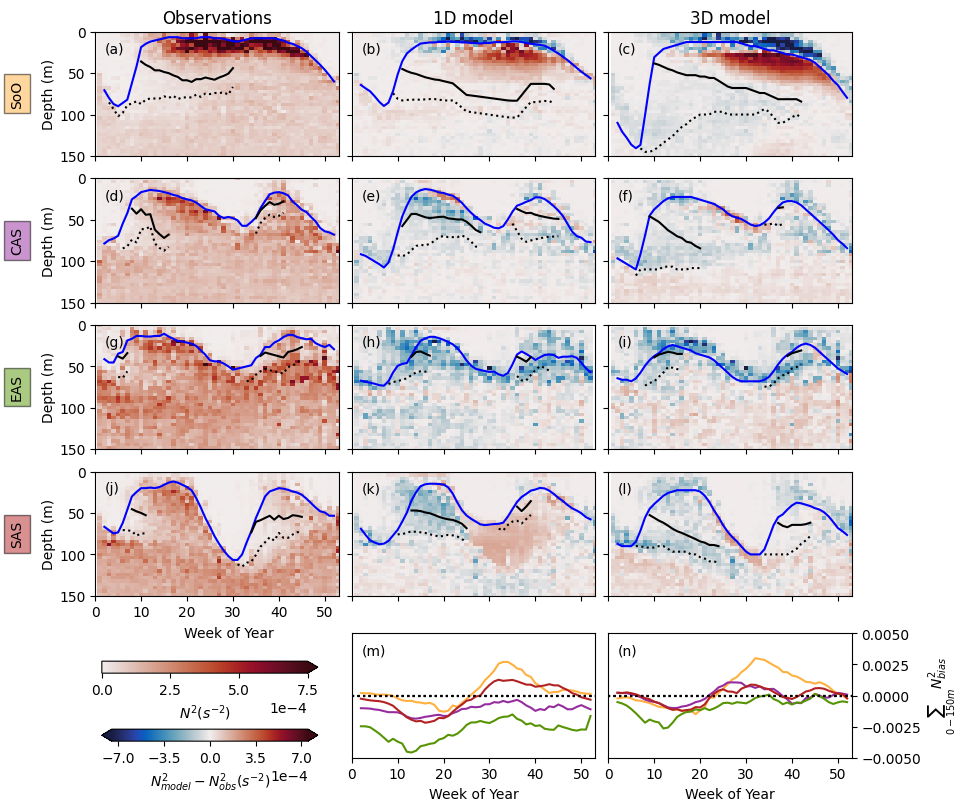

In [17]:
xx,yy=5,4
fig_sx, fig_sy=12,8

fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
    
############

for m, region in enumerate(regions):
    ax = fig.add_subplot(gs[m, 0])
    t=ax.text(x=.04,y=.83,s="(" + letters[3*m] + ')',transform=ax.transAxes, zorder=120)
    # t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    if m==0:
        ax.set_title('Observations')
    dfloat_mld=df_grid_mld_f_week.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_top=df_grid_top_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_bot=df_grid_bot_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    
    cb1=plt.pcolormesh(dfloat_n2.week, dfloat_n2.pressure_f, dfloat_n2, vmin=0, vmax=0.00075, cmap=cmo.amp)
    
    plt.xlim(0,53)
    plt.gca().set_xticks([0,10,20,30,40,50])
    # if m==3:
    #     plt.xlabel('Week of Year')
    # if m==5:
        # plt.xlabel('Week')
    # plot_mean_grid_v2('obs', region)
    
    mld_roll=dfloat_mld.rolling(week=3, center=True).mean()
    
    bot_roll=dfloat_bot.rolling(week=3, center=True).mean()
    bot_roll=bot_roll.where(bot_roll>mld_roll, np.nan)
    
    top_roll=dfloat_top.rolling(week=3, center=True).mean()
    top_roll=top_roll.where(top_roll>mld_roll, np.nan)
    if m == 2:
        top_roll=top_roll.interpolate_na(dim='week',max_gap=10)
        bot_roll=bot_roll.interpolate_na(dim='week',max_gap=10)
        
    plt.plot(dfloat_mld.week, mld_roll, c='b')
    plt.plot(dfloat_bot.week, bot_roll, c='k', ls=':')
    plt.plot(dfloat_top.week, top_roll, c='k')
 
    plt.ylim(150,0)
    # ylabel=plt.ylabel(regions_names[m] + '\n Depth (m)')
    # ylabel.set_bbox(dict(facecolor=colors_regions[m], alpha=0.5))
# Create the first part of the label
    plt.text(-0.35, 0.5, regions_names[m], transform=ax.transAxes, rotation=90, va='center', fontsize=10, bbox=dict(facecolor=colors_regions[m], alpha=0.5))
    plt.text(-0.22, 0.5, 'Depth (m)', transform=ax.transAxes, rotation=90, va='center', fontsize=10)

# Hide the default ylabel
# ax.set_ylabel('')

    if m!=3:
        plt.gca().xaxis.set_ticklabels([])
    
    ax = fig.add_subplot(gs[m, 1])
    t=ax.text(x=.04,y=.83,s="(" + letters[3*m+1] + ')',transform=ax.transAxes, zorder=120)
    if m==0:
        ax.set_title('1D model')
    plt.gca().yaxis.set_ticklabels([])
    # if m!=5:
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().set_xticks([0,10,20,30,40,50])

    # if m==5:
        # plt.xlabel('Week')
    dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
    dfloat_mld=df_grid_mld_pwp_wee.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dfloat_top=df_grid_top_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dfloat_bot=df_grid_bot_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dpwp_n2=df_grid_n2_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    
    # plt.pcolormesh(dfloat_n2.week, dfloat_n2.pressure, dfloat_n2, vmin=0, vmax=0.001, cmap=cmo.amp)
    plt.pcolormesh(dfloat_n2.week, dfloat_n2.pressure, (dpwp_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).T, cmap=cmo.balance, vmin=-0.00075, vmax=0.00075)
    
# plt.colorbar()
    plt.xlim(0,53)
    mld_roll=dfloat_mld.rolling(week=3, center=True).mean()
    bot_roll=dfloat_bot.rolling(week=3, center=True).mean()
    bot_roll=bot_roll.where(bot_roll>mld_roll, np.nan)
    top_roll=dfloat_top.rolling(week=3, center=True).mean()
    top_roll=top_roll.where(top_roll>mld_roll, np.nan)
    
    if m == 0:
        top_roll=top_roll.interpolate_na(dim='week',method='linear', max_gap=10)
        bot_roll=bot_roll.interpolate_na(dim='week',method='linear',max_gap=10)

    plt.plot(dfloat_mld.week, mld_roll, c='b')
    plt.plot(dfloat_bot.week, bot_roll, c='k', ls=':')
    plt.plot(dfloat_top.week, top_roll, c='k')
    # plot_mean_grid_v2('PWP', region)
    # plt.plot(dfloat_mld , c='b')
    # plt.plot(dfloat_top , c='k')
    # plt.plot(dfloat_bot , c='k', ls=':')
    plt.ylim(150,0)
    
    
    ax = fig.add_subplot(gs[m, 2])
    t=ax.text(x=.04,y=.83,s="(" + letters[3*m+2] + ')',transform=ax.transAxes, zorder=120)
    dfloat_mld=ds_topaz_week_mld.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dfloat_top=ds_topaz_week_tmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dfloat_bot=ds_topaz_week_bmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dtopaz_n2=ds_topaz_week_n2.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    # dtopaz_presencet=ds_presence_25percent.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest').values
    plt.gca().set_xticks([0,10,20,30,40,50])
    
    if m==0:
        ax.set_title('3D model')
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    
    cb=plt.pcolormesh(dfloat_n2.week, dfloat_n2.pressure, (dtopaz_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).T, cmap=cmo.balance, vmin=-0.00075, vmax=0.00075)

    plt.xlim(0,53)
    plt.ylim(150,0)
    mld_roll=dfloat_mld.rolling(week=3, center=True).mean()
    
    bot_roll=dfloat_bot.rolling(week=3, center=True).mean()
    bot_roll=bot_roll.where(bot_roll>mld_roll, np.nan)
    
    top_roll=dfloat_top.rolling(week=3, center=True).mean()
    top_roll=top_roll.where(top_roll>mld_roll, np.nan)
    
    plt.plot(dfloat_mld.week, mld_roll, c='b')
    plt.plot(dfloat_bot.week, bot_roll, c='k', ls=':')
    plt.plot(dfloat_top.week, top_roll, c='k')
    # plt.plot(dfloat_top.week, top_NOMW, c='k', ls=':')


cbar_ax = fig.add_axes([0.08, 0.165, 0.18, 0.015])  # left, bottom, width, height
cbar = plt.colorbar(cb1, cax=cbar_ax, ticks=[0, 0.00025, 0.0005, 0.00075], orientation='horizontal', extend='max', aspect=10)
cbar.set_label('$N^2 (s^{-2})$')
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar_ax.text(x=0.0003,y=3, s='Week of Year') 

cbar_ax = fig.add_axes([0.08, 0.08, 0.18, 0.015])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cbar_ax, ticks=[-0.0007, -0.00035, 0, 0.00035, 0.0007], orientation='horizontal', extend='both',  aspect=10)
cbar.set_label('$N^2_{model} - N^2_{obs} (s^{-2})$')
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

ax = fig.add_subplot(gs[4:, 1])
t=ax.text(x=.04,y=.83,s="(" + letters[3*m+3] + ')',transform=ax.transAxes, zorder=120)

for m, region in enumerate(regions):
    
    dpwp_n2=df_grid_n2_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
    dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
    
    dpwp_n2=dpwp_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2
    plt.plot(dtopaz_n2.week, dpwp_n2.sum('pressure').rolling(week=3, center=True).mean(), c=colors_regions[m])
    plt.ylim(-0.005,0.005)    
    plt.xlim(0,53)
    plt.gca().set_xticks([0,10,20,30,40,50])
    
    plt.axhline(0,c='k', ls=':')    
    plt.yticks([])
    plt.xlabel('Week of Year')
    

ax = fig.add_subplot(gs[4:, 2])
t=ax.text(x=.04,y=.83,s="(" + letters[3*m+4] + ')',transform=ax.transAxes, zorder=120)

for m, region in enumerate(regions):
        
    dtopaz_n2=ds_topaz_week_n2.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
    dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
    dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
    
    dtopaz_n2_=dtopaz_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2
    plt.plot(dtopaz_n2.week, dtopaz_n2_.sum('pressure').rolling(week=3, center=True).mean(), c=colors_regions[m])
    plt.ylim(-0.005,0.005) 
    plt.xlim(0,53)
    
    plt.axhline(0,c='k', ls=':')
    
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_xticks([0,10,20,30,40,50])

    plt.ylabel('$\sum_{0-150m} N^2_{bias}$')
    plt.xlabel('Week of Year')

plt.savefig('Figures/Figure8_CaseStudies.png', dpi=600, bbox_inches='tight')

In [12]:
55/110

0.5

In [54]:
region=regions[0]
print(regions_names[0])

dfloat_mld=df_grid_mld_f_week.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_top=df_grid_top_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_bot=df_grid_bot_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')

# plt.plot(dfloat_mld)
# plt.ylim(20,0)
print('\n ARGO')
print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[15:40]), np.nanstd(dfloat_mld[15:40]))

print('mean summer to fall upper ocean stratif')
print(np.nanmean(dfloat_n2[15:40]), np.nanstd(dfloat_n2[15:40]))


dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
dfloat_mld=df_grid_mld_pwp_wee.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dfloat_top=df_grid_top_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dfloat_bot=df_grid_bot_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dpwp_n2=df_grid_n2_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dpwp_n2_=(dpwp_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).sum('pressure')

print('\n gotm')
print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[15:40]), np.nanstd(dfloat_mld[15:40]))
print('mean summer to fall upper ocean stratif')
print(np.nanmean(dpwp_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]), np.nanstd(dpwp_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]))


dfloat_mld=ds_topaz_week_mld.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dfloat_top=ds_topaz_week_tmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dfloat_bot=ds_topaz_week_bmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dtopaz_n2=ds_topaz_week_n2.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')

dtopaz_n2_=(dtopaz_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).sum('pressure')
print('\n TOPAZ')

print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[15:40]), np.nanstd(dfloat_mld[15:40]))
print('mean summer to fall upper ocean stratif')
print(np.nanmean(dtopaz_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]), np.nanstd(dtopaz_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]))


SoO

 ARGO
max winter mixed layer depth
94.0
mean summer to fall mixed layer depth
8.24 1.8172506706560876
mean summer to fall upper ocean stratif
7.198921033291228e-05 2.9643469500947913e-05

 gotm
max winter mixed layer depth
93.0
mean summer to fall mixed layer depth
13.0 1.2328828005937953
mean summer to fall upper ocean stratif
7.996329457717521 17.13414474129995

 TOPAZ
max winter mixed layer depth
145.0
mean summer to fall mixed layer depth
16.7 5.418486873657626
mean summer to fall upper ocean stratif
12.003822777316422 18.554975222038017


In [64]:
# regions[1]

In [125]:
region=regions[1]
print(regions_names[1])

dfloat_mld=df_grid_mld_f_week.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_top=df_grid_top_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_bot=df_grid_bot_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')

# plt.plot(dfloat_mld)
# plt.ylim(20,0)
print('\n ARGO')
print('max winter mixed layer depth')
print(np.nanmean(dfloat_mld[:7]))
print(np.nanstd(dfloat_mld[:7]),)
# print(dfloat_mld[:15])

print('max winter mixed layer depth')
print(np.nanmean(dfloat_mld[25:35]))
print(np.nanstd(dfloat_mld[25:35]),)
# print(dfloat_mld[:15])

print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[10:20]), np.nanstd(dfloat_mld[15:25]))

print('mean ALL mixed layer depth')
print(np.nanmean(dfloat_mld[:]), np.nanstd(dfloat_mld[:]))

print('mean summer to fall upper ocean stratif')
print(np.nanmean(dfloat_n2[15:40]), np.nanstd(dfloat_n2[15:40]))

print(np.nanmedian(dfloat_bot-dfloat_top))
print(np.nanstd(dfloat_bot-dfloat_top))

dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
dfloat_mld=df_grid_mld_pwp_wee.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dfloat_top=df_grid_top_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dfloat_bot=df_grid_bot_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dpwp_n2=df_grid_n2_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dpwp_n2_=(dpwp_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).sum('pressure')

print('\n gotm')
print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[10:20]), np.nanstd(dfloat_mld[15:25]))
print('mean summer to fall upper ocean stratif')
print(np.nanmean(dpwp_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]), np.nanstd(dpwp_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]))


print('mean ALL mixed layer depth')
print(np.nanmean(dfloat_mld[:]), np.nanstd(dfloat_mld[:]))

print(np.nanmedian(dfloat_bot-dfloat_top))
print(np.nanstd(dfloat_bot-dfloat_top))

dfloat_mld=ds_topaz_week_mld.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dfloat_top=ds_topaz_week_tmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dfloat_bot=ds_topaz_week_bmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dtopaz_n2=ds_topaz_week_n2.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')

dtopaz_n2_=(dtopaz_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).sum('pressure')
print('\n TOPAZ')

print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[10:20]), np.nanstd(dfloat_mld[15:25]))
print('mean summer to fall upper ocean stratif')
print(np.nanmean(dtopaz_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]), np.nanstd(dtopaz_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]))


print('mean ALL mixed layer depth')
print(np.nanmean(dfloat_mld[:]), np.nanstd(dfloat_mld[:]))


print(np.nanmedian(dfloat_bot-dfloat_top))
print(np.nanstd(dfloat_bot-dfloat_top))


CAS

 ARGO
max winter mixed layer depth
68.0
16.24807680927192
max winter mixed layer depth
49.4
8.765842800324451
mean summer to fall mixed layer depth
18.4 7.031358332498778
mean ALL mixed layer depth
39.698113207547166 20.489836326003907
mean summer to fall upper ocean stratif
0.00012567993408035572 5.6505187134576595e-05
16.0
13.813777609439207

 gotm
max winter mixed layer depth
111.0
mean summer to fall mixed layer depth
20.6 7.255342858886822
mean summer to fall upper ocean stratif
-13.250987980650134 6.802293789311811
mean ALL mixed layer depth
49.490566037735846 28.542998111428926
24.5
7.78585889709235

 TOPAZ
max winter mixed layer depth
110.0
mean summer to fall mixed layer depth
24.5 5.0
mean summer to fall upper ocean stratif
3.3660551658496383 9.125382525720044
mean ALL mixed layer depth
50.613207547169814 26.20972049073029
36.0
21.654684186619352


In [2]:
region=regions[2]
print(regions_names[2])

dfloat_mld=df_grid_mld_f_week.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_top=df_grid_top_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_bot=df_grid_bot_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')
dfloat_n2=df_grid_n2_f.sel(latitude_f_bins=region[0], method='nearest').sel(longitude_f_bins=region[1], method='nearest')

# plt.plot(dfloat_mld)
# plt.ylim(20,0)
print('\n ARGO')
print('max winter mixed layer depth')
print(np.nanmean(dfloat_mld[:7]))
print(np.nanstd(dfloat_mld[:7]),)
# print(dfloat_mld[:15])

print('max winter mixed layer depth')
print(np.nanmean(dfloat_mld[25:35]))
print(np.nanstd(dfloat_mld[25:35]),)
# print(dfloat_mld[:15])

print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[10:20]), np.nanstd(dfloat_mld[15:25]))

print('mean ALL mixed layer depth')
print(np.nanmean(dfloat_mld[:]), np.nanstd(dfloat_mld[:]))

print('mean summer to fall upper ocean stratif')
print(np.nanmean(dfloat_n2[15:40]), np.nanstd(dfloat_n2[15:40]))

print(np.nanmedian(dfloat_bot-dfloat_top))
print(np.nanstd(dfloat_bot-dfloat_top))

dfloat_n2=dfloat_n2.rename({'pressure_f':'pressure'})    
dfloat_mld=df_grid_mld_pwp_wee.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dfloat_top=df_grid_top_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dfloat_bot=df_grid_bot_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dpwp_n2=df_grid_n2_pwp.sel(latitude_bins=region[0], method='nearest').sel(longitude_bins=region[1], method='nearest')
dpwp_n2_=(dpwp_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).sum('pressure')

print('\n gotm')
print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[10:20]), np.nanstd(dfloat_mld[15:25]))
print('mean summer to fall upper ocean stratif')
print(np.nanmean(dpwp_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]), np.nanstd(dpwp_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]))


print('mean ALL mixed layer depth')
print(np.nanmean(dfloat_mld[:]), np.nanstd(dfloat_mld[:]))

print(np.nanmedian(dfloat_bot-dfloat_top))
print(np.nanstd(dfloat_bot-dfloat_top))

dfloat_mld=ds_topaz_week_mld.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dfloat_top=ds_topaz_week_tmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dfloat_bot=ds_topaz_week_bmwl.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')
dtopaz_n2=ds_topaz_week_n2.sel(latitude=region[0], method='nearest').sel(longitude=region[1], method='nearest')

dtopaz_n2_=(dtopaz_n2.interp_like('pressure'==dfloat_n2.pressure)-dfloat_n2).sum('pressure')
print('\n TOPAZ')

print('max winter mixed layer depth')
print(np.nanmax(dfloat_mld[:15]))
print('mean summer to fall mixed layer depth')
print(np.nanmean(dfloat_mld[10:20]), np.nanstd(dfloat_mld[15:25]))
print('mean summer to fall upper ocean stratif')
print(np.nanmean(dtopaz_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]), np.nanstd(dtopaz_n2_[15:40])*100/np.nanmean(dfloat_n2.sum('pressure')[15:40]))


print('mean ALL mixed layer depth')
print(np.nanmean(dfloat_mld[:]), np.nanstd(dfloat_mld[:]))


print(np.nanmedian(dfloat_bot-dfloat_top))
print(np.nanstd(dfloat_bot-dfloat_top))


NameError: name 'regions' is not defined

In [147]:
## SCALING OF MLD

(0.0, 1.0)

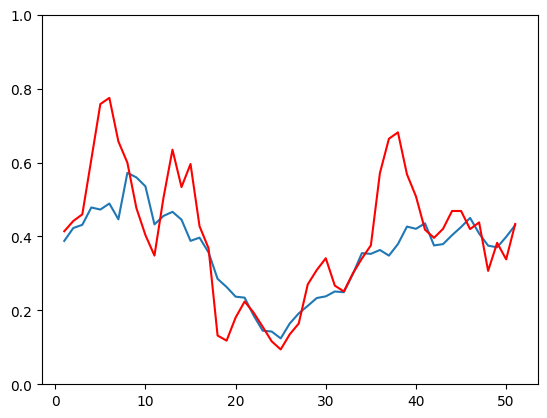

In [185]:
upsis_topaz=ds_topaz_week_mld.interp_like('latitude'==df_grid_mld_f_week.latitude_f_bins.rename({'latitude_f_bins':'latitude'})).interp_like('longitude'==df_grid_mld_f_week.longitude_f_bins.rename({'longitude_f_bins':'longitude'}))
upsis_argo=df_grid_mld_f_week.rename({'latitude_f_bins':'latitude'}).rename({'longitude_f_bins':'longitude'})

# for i in range(54):
#     plt.pcolormesh(((upsis_topaz-upsis_argo)/upsis_argo)[i], vmin=-0.5, vmax=0.5, cmap=cmo.balance)
#     plt.colorbar()
#     plt.show()

plt.plot(((upsis_topaz-upsis_argo)/upsis_argo).where(upsis_argo.latitude<20, drop=True).median('latitude').median('longitude').rolling(week=3, center=True).mean())
plt.plot(((upsis_topaz-upsis_argo)/upsis_argo).where(upsis_argo.latitude>20, drop=True).median('latitude').median('longitude').rolling(week=3, center=True).mean(), c='r')
plt.ylim(0,1)

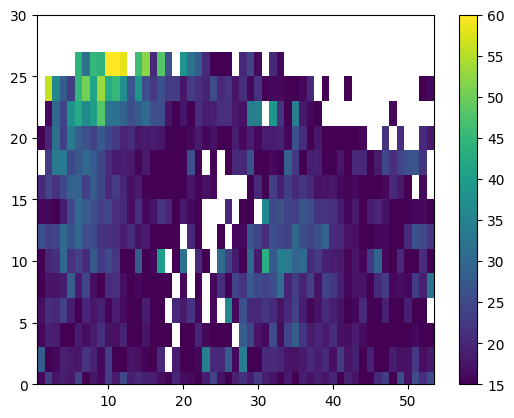

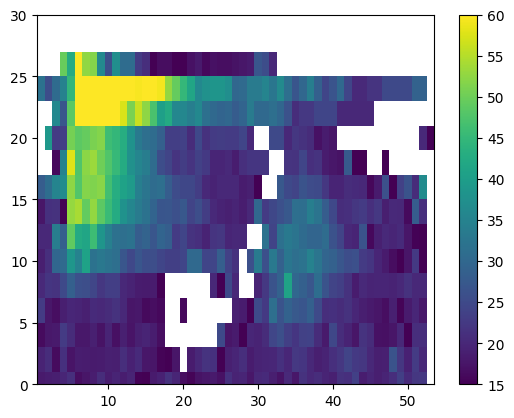

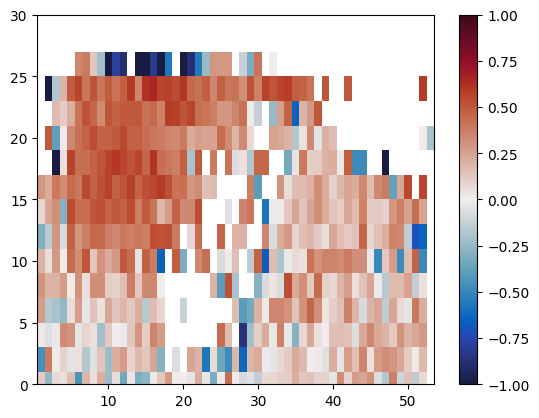

(0.0, 1.0)

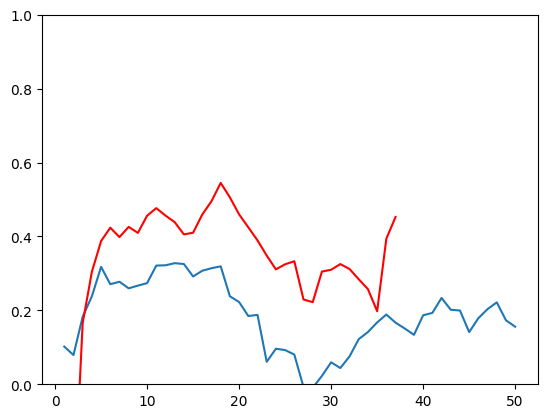

In [230]:
upsis_topaz=(ds_topaz_week_bmwl-ds_topaz_week_tmwl).interp_like('latitude'==df_grid_mld_f_week.latitude_f_bins.rename({'latitude_f_bins':'latitude'})).interp_like('longitude'==df_grid_mld_f_week.longitude_f_bins.rename({'longitude_f_bins':'longitude'}))
upsis_argo=(df_grid_bot_f-df_grid_top_f).rename({'latitude_f_bins':'latitude'}).rename({'longitude_f_bins':'longitude'})

plt.pcolormesh(df_grid_bot_f.week, df_grid_bot_f.latitude_f_bins, (df_grid_bot_f-df_grid_top_f).mean('longitude_f_bins').T, vmin=15, vmax=60)
plt.colorbar()
plt.ylim(0,30)

plt.show()

plt.pcolormesh(ds_topaz_week_tmwl.week, df_grid_bot_f.latitude_f_bins, (ds_topaz_week_bmwl-ds_topaz_week_tmwl).interp_like('latitude'==df_grid_mld_f_week.latitude_f_bins.rename({'latitude_f_bins':'latitude'})).interp_like('longitude'==df_grid_mld_f_week.longitude_f_bins.rename({'longitude_f_bins':'longitude'})).mean('longitude'), vmin=15, vmax=60)
plt.colorbar()
plt.ylim(0,30)
plt.show()


difference_percent=(1-((df_grid_bot_f-df_grid_top_f).mean('longitude_f_bins').T).values/(ds_topaz_week_bmwl-ds_topaz_week_tmwl).interp_like('latitude'==df_grid_mld_f_week.latitude_f_bins.rename({'latitude_f_bins':'latitude'})).interp_like('longitude'==df_grid_mld_f_week.longitude_f_bins.rename({'longitude_f_bins':'longitude'})).mean('longitude'))

plt.pcolormesh(ds_topaz_week_tmwl.week,df_grid_bot_f.latitude_f_bins, difference_percent,     vmin=-1, vmax=1, cmap=cmo.balance)
plt.colorbar()
plt.ylim(0,30)
plt.show()

plt.plot(difference_percent.where(difference_percent.latitude<20, drop=True).median('latitude').rolling(week=3, center=True).mean())
plt.plot(difference_percent.where(difference_percent.latitude>20, drop=True).median('latitude').rolling(week=3, center=True).mean(), c='r')
plt.ylim(0,1)

In [228]:
difference_percent.where(difference_percent.latitude<20, drop=True)

<xarray.DataArray (latitude: 12, week: 53)>
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
...
         2.42105263e-01,  5.47169811e-01,             nan,
         5.61643836e-01,             nan],
       [            nan,             nan, -1.08333333e+00,
         4.76190476e-02,  5.67099567e-01,  4.33707865e-01,
         4.24657534e-01,  4.73825503e-01,  5.11111111e-01,
         5.64875491e-01,  6.00554785e-01,  5.56954059e-01,
         5.11111111e-01,  5.60563380e-01,  4.57794208e-01,
         6.09756098e-01,  4.23220974e-01,  4.02666667e-01,
         3.73684211e-01,  4.80144404e-01, -1.98156682e-01,
         4.93670886e-01,             nan,  3.88535032e-01,
                    nan,  4.07407407e-01, -7.14285714e-02,
         4.76190476e-02, -1.81818182e-01,  4.54545455e-01,
         4.54545455e-01,             nan,             nan,
        -3.30783939e-01, -3.39506173e-02,  3.93103448e-01,
         1.04761905e-01,  1.13072256e-01,  1.96185286e-01,
         2.11267606e-01, -2.02898551e-02,  4.78787879e-01,
        -4.81481481e-01, -4.81481481e-01,             nan,
                    nan, -1.34920635e+00,             nan,
                    nan,             nan,             nan,
                    nan,             nan]])
Coordinates:
  * week      (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
  * latitude  (latitude) float64 -4.0 -2.0 0.0 2.0 4.0 ... 12.0 14.0 16.0 18.0